In [2]:
# Libraries
import os
from PIL import Image, ImageEnhance
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import classification_report, accuracy_score


Preprocessing

In [2]:
def preprocess_image(image_path, size=(224, 224)):
    img = Image.open(image_path)
    
    # Quality enhancement
    enhancer = ImageEnhance.Sharpness(img)
    img = enhancer.enhance(2.0)  # Increase sharpness
    
    # Noise reduction
    image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # Consistency
    img = img.resize(size, Image.LANCZOS)
    
    # Normalization
    img_array = np.array(img) / 255.0
    
    # Convert back to image
    img = Image.fromarray((img_array * 255).astype(np.uint8))
    
    return img

# Apply preprocessing and save to new directory
input_dir = 'images_train_test_val/train'
output_dir = 'processed_images'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for category in os.listdir(input_dir):
    category_path = os.path.join(input_dir, category)
    if os.path.isdir(category_path):
        output_category_path = os.path.join(output_dir, category)
        if not os.path.exists(output_category_path):
            os.makedirs(output_category_path)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            preprocessed_img = preprocess_image(image_path)
            preprocessed_img.save(os.path.join(output_category_path, image_name))

Train/Test Split

In [3]:
train_dir = 'processed_images'
# train_dir = 'images_train_test_val/train'
val_dir = 'images_train_test_val/validation'
test_dir = 'images_train_test_val/test'

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    # brightness_range=[0.8, 1.2],  # Randomly adjust brightness
    # rotation_range=20,  # Randomly rotate images
    # width_shift_range=0.2,  # Randomly shift images horizontally
    # height_shift_range=0.2  # Randomly shift images vertically
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)


test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 10500 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.
Found 1050 images belonging to 21 classes.


Base Model Creation

In [4]:
def create_model(optimizer='adam', init_mode='uniform'):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu', kernel_initializer=init_mode))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer=init_mode))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init_mode))
    model.add(Dropout(0.5))
    model.add(Dense(21, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

Model Creation

In [5]:
model = create_model()
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)

c:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


c:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


165/165 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.0605 - loss: 3.0523 - val_accuracy: 0.0943 - val_loss: 2.9693
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.0927 - loss: 2.8975 - val_accuracy: 0.1329 - val_loss: 2.7494
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.1363 - loss: 2.7314 - val_accuracy: 0.1819 - val_loss: 2.5685
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.1718 - loss: 2.6097 - val_accuracy: 0.2452 - val_loss: 2.4065
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.2181 - loss: 2.4605 - val_accuracy: 0.2762 - val_loss: 2.2434
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.2379 - loss: 2.3858 - val_accuracy: 0.3167 - val_loss: 2.1507
Epoch 7/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.2878 - loss: 2.2416 - val_accuracy: 0.3186 - val_loss: 2.0815
Epoch 8/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.3094 - loss: 2.1952 - val_accuracy: 0.371

In [6]:
# Evaluate the model
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(val_generator)
test_loss, test_acc = model.evaluate(test_generator)

print(f'Train accuracy: {train_acc:.4f}, Validation accuracy: {val_acc:.4f}, Test accuracy: {test_acc:.4f}')

165/165 ━━━━━━━━━━━━━━━━━━━━ 88s 530ms/step - accuracy: 0.5815 - loss: 1.3129
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 568ms/step - accuracy: 0.5070 - loss: 1.5547
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 582ms/step - accuracy: 0.4983 - loss: 1.4866
Train accuracy: 0.5808, Validation accuracy: 0.5252, Test accuracy: 0.5143


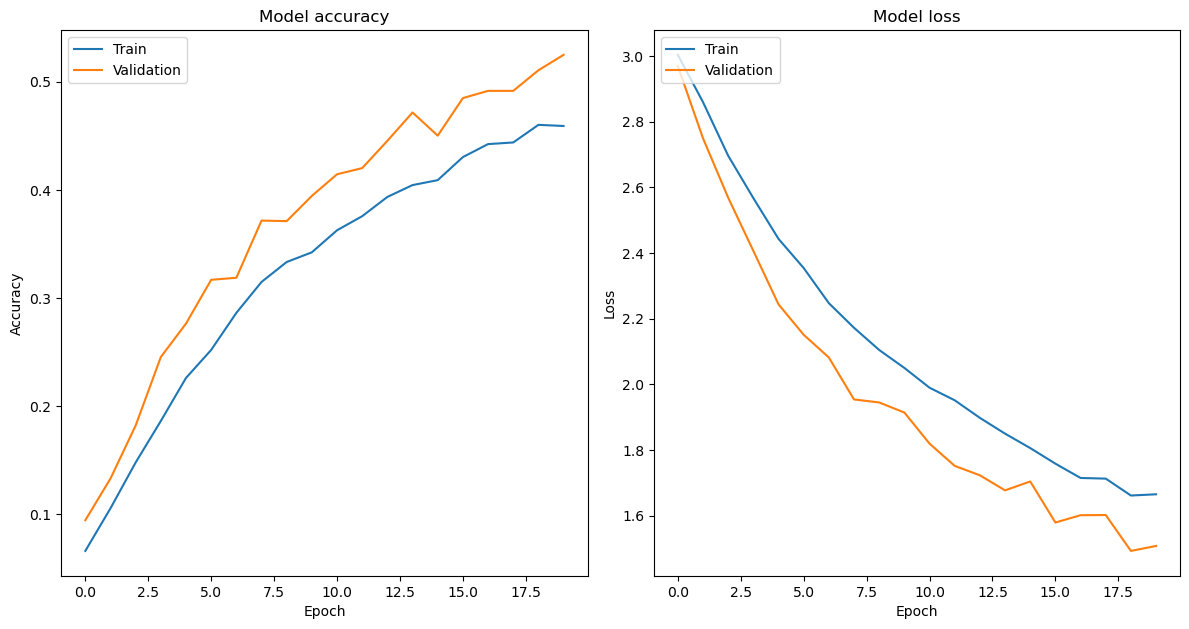

In [7]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [1]:
from sklearn.metrics import classification_report, confusion_matrix

test_generator.reset()
Y_pred = model.predict(test_generator, len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))
cm = confusion_matrix(test_generator.classes, y_pred)
print(cm)

NameError: name 'test_generator' is not defined